In [1]:
import numpy as np
import pandas as pd
import random as rd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import all csv file data

sales = pd.read_csv( 'data/sales_train.csv')

# Warnings
import warnings
warnings.filterwarnings('ignore')

item_cat = pd.read_csv( 'data/item_categories.csv')
item = pd.read_csv( 'data/items.csv')
sub = pd.read_csv( 'data/sample_submission.csv')
shops = pd.read_csv( 'data/shops.csv')
test = pd.read_csv( 'data/test.csv')

In [3]:
# Reformat the date column
sales.date = sales.date.apply( lambda x: datetime.datetime.strptime( x, '%d.%m.%Y' ) )

# Add month and year columns
sales['month'] = [ x.month for x in sales.date ]
sales['year'] = [ x.year for x in sales.date ]
sales['year_month'] = sales.year * 100 + sales.month

# Add the item_category_id to the training set
sales = sales.set_index('item_id').join(item.set_index('item_id')).drop('item_name', axis=1).reset_index()
test = test.set_index('item_id').join(item.set_index('item_id')).drop('item_name', axis=1).reset_index()

# Add a unique id for the shop + item combo
sales['shop_item_id'] = sales.shop_id + sales.item_id * 100
test['shop_item_id'] = test.shop_id + test.item_id * 100
sales['shop_cat_id'] = sales.shop_id + sales.item_category_id * 100
test['shop_cat_id'] = test.shop_id + test.item_category_id * 100

# Add the revenue
sales[ "revenue" ] = sales.item_price * sales.item_cnt_day

In [6]:
# Split into train and validation set
train = sales[ sales.year_month < 201510 ]
valid = sales[ sales.year_month == 201510 ]

In [7]:
# See how many shop/item combinations are present in the test set and have never been seen before

A = test[ test.shop_item_id.isin( sales.shop_item_id )]
B = test[ ~test.shop_item_id.isin( sales.shop_item_id )]

print( 'Number of new shop/item combos seen in test set: {}. Total test items: {}'.format(len(B), len(test)) )

C = valid[ valid.shop_item_id.isin( train.shop_item_id )]
D = valid[ ~valid.shop_item_id.isin( train.shop_item_id )]

print( 'Number of new shop/item combos seen in validation set: {}. Total validation items: {}'.format(len(D), len(valid)) )

Number of new shop/item combos seen in test set: 102796. Total test items: 214200
Number of new shop/item combos seen in validation set: 12334. Total validation items: 53514


In [4]:
agg_rules = {'item_price' : "mean", "revenue" : "sum", "item_cnt_day" : "sum" }
sales_monthly = sales.groupby([ "year_month", "shop_id", "item_id", "item_category_id", "shop_item_id", "shop_cat_id" ] ).agg( agg_rules ).reset_index()

agg_rules = {'item_price' : "mean", "revenue" : "sum", "item_cnt_day" : "sum", "shop_id" : "count", "item_id" : "count" }
sales_monthly_cat = sales_monthly.groupby([ "year_month", "item_category_id" ] ).agg( agg_rules ).reset_index()

agg_rules = {'item_price' : "mean", "revenue" : "sum", "item_cnt_day" : "sum", "item_category_id" : "count", "item_id" : "count" }
sales_monthly_shop = sales_monthly.groupby([ "year_month", "shop_id" ] ).agg( agg_rules ).reset_index()

agg_rules = {'item_price' : "mean", "revenue" : "sum", "item_cnt_day" : "sum", "shop_id" : "count" }
sales_monthly_item = sales_monthly.groupby([ "year_month", "item_id" ] ).agg( agg_rules ).reset_index()

agg_rules = {'item_price' : "mean", "revenue" : "sum", "item_cnt_day" : "sum" }
sales_monthly_shop_item = sales_monthly.groupby([ "year_month", "shop_item_id", "item_id", "shop_id", "item_category_id" ] ).agg( agg_rules ).reset_index()

agg_rules = {'item_price' : "mean", "revenue" : "sum", "item_cnt_day" : "sum", "item_id" : "sum" }
sales_monthly_shop_cat = sales_monthly.groupby([ "year_month", "shop_cat_id", "item_category_id", "shop_id" ] ).agg( agg_rules ).reset_index()

(array([41.,  9.,  3.,  0.,  2.,  2.,  1.,  3.,  0.,  2.]),
 array([1.0000e+00, 7.1160e+02, 1.4222e+03, 2.1328e+03, 2.8434e+03,
        3.5540e+03, 4.2646e+03, 4.9752e+03, 5.6858e+03, 6.3964e+03,
        7.1070e+03]),
 <a list of 10 Patch objects>)

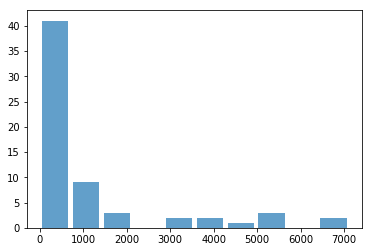

In [5]:
sales_monthly_cat.sort_values(by="item_cnt_day", ascending=False)

plt.hist(sales_monthly_cat[ sales_monthly_cat.year_month == 201509 ].item_cnt_day, alpha=0.7, rwidth=0.85)

Text(0.5, 1.0, 'Log Distribution of Items sold per shop in 2015')

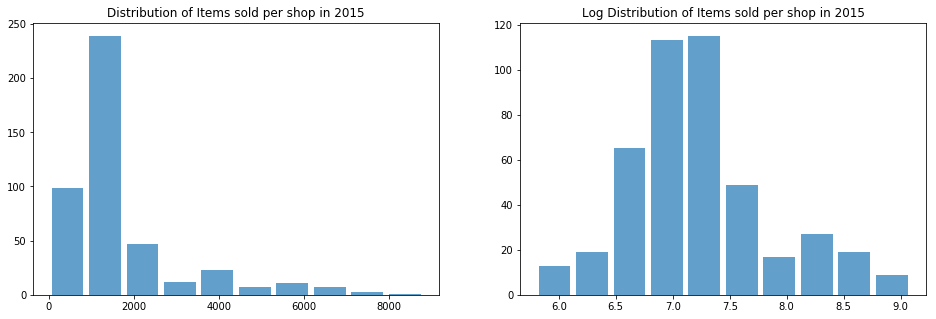

In [20]:
sales_monthly_shop.sort_values(by="item_cnt_day", ascending=False)

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.hist( sales_monthly_shop[ sales_monthly_shop.year_month >= 201501 ].item_cnt_day, alpha=0.7, rwidth=0.85)
plt.title( "Distribution of Items sold per shop in 2015" )

plt.subplot(1,2,2)
plt.hist(np.log( sales_monthly_shop[ sales_monthly_shop.year_month >= 201501 ].item_cnt_day), alpha=0.7, rwidth=0.85)
plt.title( "Log Distribution of Items sold per shop in 2015" )

[[1.        0.8129659]
 [0.8129659 1.       ]]


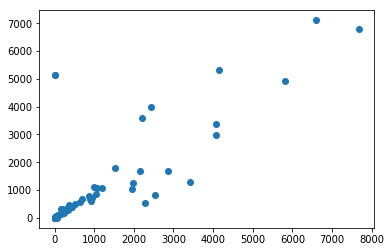

In [217]:
# Persistence of item categories from month to month

y1 = 201510
y2 = 201509

x1 = np.zeros( (sales.item_category_id.max(),1) )
x2 = np.zeros( (sales.item_category_id.max(),1) )

s1 = sales_monthly_cat[ sales_monthly_cat.year_month == y1 ]
s2 = sales_monthly_cat[ sales_monthly_cat.year_month == y2 ]

for j in range(len(x1)):

    tmp_1 = s1[ s1.item_category_id == j ]
    if len(tmp_1) > 0:
        x1[j] = float(tmp_1.item_cnt_day )
        
    tmp_2 = s2[ s2.item_category_id == j ]        
    if len(tmp_2) > 0:
        x2[j] = float( tmp_2.item_cnt_day )

plt.scatter( x1, x2 )
print( np.corrcoef(x1.T, x2.T) )

[[1.         0.60877303]
 [0.60877303 1.        ]]


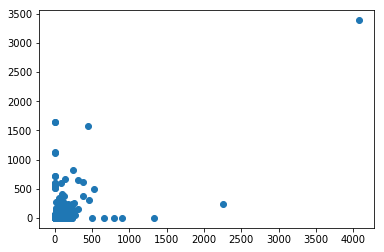

In [228]:
# Persistence of items from month to month

y1 = 201510
y2 = 201509

x1 = np.zeros( (sales.item_id.max(),1) )
x2 = np.zeros( (sales.item_id.max(),1) )

s1 = sales_monthly_item[ sales_monthly_item.year_month == y1 ]
s2 = sales_monthly_item[ sales_monthly_item.year_month == y2 ]

for j in range(len(x1)):

    tmp_1 = s1[ s1.item_id == j ]
    if len(tmp_1) > 0:
        x1[j] = float( tmp_1.item_cnt_day )
        
    tmp_2 = s2[ s2.item_id == j ]        
    if len(tmp_2) > 0:
        x2[j] = float( tmp_2.item_cnt_day )

plt.scatter( x1, x2 )
print( np.corrcoef(x1.T, x2.T) )


[[1.         0.83583757]
 [0.83583757 1.        ]]


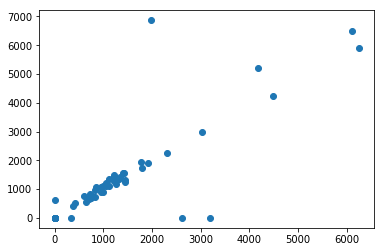

In [229]:
# Persistence of shops from month to month

y1 = 201510
y2 = 201509

x1 = np.zeros( (sales.shop_id.max(),1) )
x2 = np.zeros( (sales.shop_id.max(),1) )

s1 = sales_monthly_shop[ sales_monthly_shop.year_month == y1 ]
s2 = sales_monthly_shop[ sales_monthly_shop.year_month == y2 ]

for j in range(len(x1)):

    tmp_1 = s1[ s1.shop_id == j ]
    if len(tmp_1) > 0:
        x1[j] = float( tmp_1.item_cnt_day )
        
    tmp_2 = s2[ s2.item_id == j ]        
    if len(tmp_2) > 0:
        x2[j] = float( tmp_2.item_cnt_day )

plt.scatter( x1, x2 )
print( np.corrcoef(x1.T, x2.T) )

[[1.         0.17517976]
 [0.17517976 1.        ]]


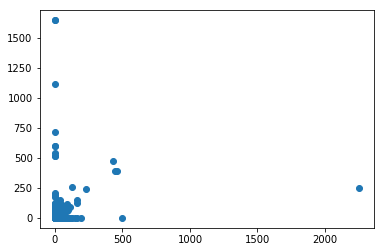

In [249]:
# Persistence of shop-items from month to month

y1 = 201510
y2 = 201509

s1 = sales_monthly_shop_item[ sales_monthly_shop_item.year_month == y1 ]
s2 = sales_monthly_shop_item[ sales_monthly_shop_item.year_month == y2 ]

sc_ids_1 = set(s1.shop_item_id)
sc_ids_2 = set(s2.shop_item_id)
sc_ids = list(sc_ids_1.union(sc_ids_2))

x1 = np.zeros( (len(sc_ids),1) )
x2 = np.zeros( (len(sc_ids),1) )

for j in range(len(x1)):

    id_j = sc_ids[j]
    
    tmp_1 = s1[ s1.shop_item_id == id_j ]
    if len(tmp_1) > 0:
        x1[j] = float( tmp_1.item_cnt_day )
        
    tmp_2 = s2[ s2.shop_item_id == id_j ]        
    if len(tmp_2) > 0:
        x2[j] = float( tmp_2.item_cnt_day )

plt.scatter( x1, x2 )
print( np.corrcoef(x1.T, x2.T) )


[[1.         0.36459748]
 [0.36459748 1.        ]]


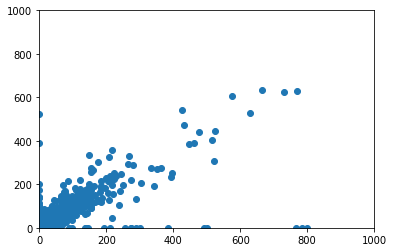

In [273]:
# Persistence of shop-category from month to month

y1 = 201510
y2 = 201509

s1 = sales_monthly_shop_cat[ sales_monthly_shop_cat.year_month == y1 ]
s2 = sales_monthly_shop_cat[ sales_monthly_shop_cat.year_month == y2 ]

sc_ids_1 = set(s1.shop_cat_id)
sc_ids_2 = set(s2.shop_cat_id)
sc_ids = list(sc_ids_1.union(sc_ids_2))

x1 = np.zeros( (len(sc_ids),1) )
x2 = np.zeros( (len(sc_ids),1) )

for j in range(len(x1)):

    id_j = sc_ids[j]
    
    tmp_1 = s1[ s1.shop_cat_id == id_j ]
    if len(tmp_1) > 0:
        x1[j] = float( tmp_1.item_cnt_day )
        
    tmp_2 = s2[ s2.shop_cat_id == id_j ]        
    if len(tmp_2) > 0:
        x2[j] = float( tmp_2.item_cnt_day )

plt.scatter( x1, x2 )
plt.xlim(0,1000)
plt.ylim(0,1000)
print( np.corrcoef(x1.T, x2.T) )

In [200]:
import statsmodels.graphics.gofplots

sales_201510 = sales_monthly[sales_monthly.year_month == 201510]
sales_item_201510 = sales_monthly_item[sales_monthly_item.year_month == 201510]


(array([2.1351e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0700e+03,
        0.0000e+00, 0.0000e+00, 1.9070e+03, 9.5900e+02, 0.0000e+00,
        5.8200e+02, 3.4100e+02, 2.2600e+02, 1.5800e+02, 2.4100e+02,
        6.5000e+01, 1.1700e+02, 1.3000e+02, 4.6000e+01, 5.3000e+01,
        4.4000e+01, 4.4000e+01, 4.0000e+01, 1.5000e+01, 1.2000e+01,
        1.2000e+01, 1.6000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.15440036, 0.30880072, 0.46320108, 0.61760144,
        0.77200179, 0.92640215, 1.08080251, 1.23520287, 1.38960323,
        1.54400359, 1.69840395, 1.85280431, 2.00720466, 2.16160502,
        2.31600538, 2.47040574, 2.6248061 , 2.77920646, 2.93360682,
        3.08800718, 3.24240753, 3.39680789, 3.

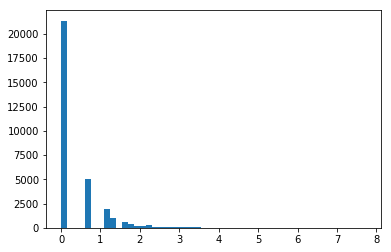

In [202]:
plt.hist( np.log(sales_201510.item_cnt_day[sales_201510.item_cnt_day>0]), bins=50 )

(array([1.427e+03, 0.000e+00, 0.000e+00, 0.000e+00, 7.050e+02, 0.000e+00,
        4.490e+02, 0.000e+00, 3.740e+02, 2.840e+02, 2.210e+02, 1.570e+02,
        1.810e+02, 2.780e+02, 1.910e+02, 1.610e+02, 1.210e+02, 1.360e+02,
        1.400e+02, 8.000e+01, 8.500e+01, 8.600e+01, 7.200e+01, 5.500e+01,
        4.700e+01, 4.000e+01, 3.400e+01, 1.300e+01, 1.700e+01, 1.400e+01,
        6.000e+00, 9.000e+00, 1.000e+01, 3.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.        , 0.16626724, 0.33253448, 0.49880172, 0.66506896,
        0.8313362 , 0.99760343, 1.16387067, 1.33013791, 1.49640515,
        1.66267239, 1.82893963, 1.99520687, 2.16147411, 2.32774135,
        2.49400859, 2.66027582, 2.82654306, 2.9928103 , 3.15907754,
        3.32534478, 3.49161202, 3.65787926, 3.8241465 , 3.99041374,
        4.15668098, 4.32294821, 4.48

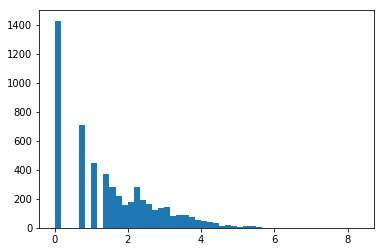

In [203]:
plt.hist( np.log(sales_item_201510.item_cnt_day[sales_item_201510.item_cnt_day>0]), bins=50 )

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from fbprophet import Prophet
import datetime
    
class PCADecomp():
    
    def __init__(self, sales_monthly, pivot_column, method="pca_simple", \
                 begin_idx=0, end_idx=None, n_pca_components=10, n_fcst_periods=1 ):
        
        self.sales_monthly = sales_monthly
        self.pivot_column = pivot_column
        self.n_fcst_periods = n_fcst_periods
        self.method = method

        self.n_pca_components = n_pca_components
        self.begin_idx = begin_idx
        
        if end_idx is None:
            self.end_idx = len(self.sales_monthly)-1
        else:
            self.end_idx = end_idx

        # Calculate the time series for the given pivot column
        self.ts_full = create_pivot_ts( self.sales_monthly, self.pivot_column )

    def forecast(self):
        
        self.mu = self.ts_full.mean(axis=0).to_numpy().reshape((1,self.ts_full.shape[1]))
        ts_demean = pred.ts_full - self.mu
        
        self.y = ts_demean.iloc[-self.n_fcst_periods:]
        self.X = ts_demean.iloc[:-self.n_fcst_periods]
 
        # Fit the PCA
        self.pca = PCA(n_components=self.n_pca_components)

        self.pca.fit(self.X)

        # Find the factors according to the PCA
        self.X_factors = np.matmul( ts_demean.to_numpy(), self.pca.components_.T )        
        
        # Make forecasts for the factors
        self._forecast_factors()
        
        # Concat the forecast time series with the existing time series
        self.X_full = np.vstack( [ self.X_factors, self.X_forecast ] )
        
        # Save the result as 'yhat'
        yhat_demeaned = self.pca.inverse_transform(self.X_full)
        self.yhat = yhat_demeaned + self.mu
        
        
    def _forecast_factors(self):
        
        if self.method == "pca_simple":
            self._forecast_factors_simple()
        elif self.method == "pca_prophet":
            self._forecast_factors_prophet()
         

    def _forecast_factors_simple(self):
        """Forecast that the PCA factors stay constant into the future."""
        
        N = self.n_fcst_periods
        self.X_forecast = self.X_factors[-N,:]
        for j in range(1,N):
            self.X_forecast = np.vstack( [ self.X_forecast, self.X_factors[-N+j,:] ] )
                
        
    def _forecast_factors_prophet( self, n_fcst_periods=1 ):
        #prophet reqiures a pandas df at the below config 
        # ( date column named as DS and the value column as Y)

        yhat = None
        for j in range(self.n_pca_components):
            # Get the j-th principal component
            fcst = self.forecast_pca_prophet_single( component_idx=j, n_fcst_periods=n_fcst_periods )

            # Convert the fitted time series to a data frame, and rename
            new_yhat = fcst.yhat.to_frame().copy()
            new_yhat.columns = pd.Index([ "y_" + "{:02}".format(j) ])

            if yhat is None:
                yhat = new_yhat
            else:
                yhat = pd.concat( [ yhat, new_yhat ], axis=1 )

        self.yhat = yhat
        
        
    def _forecast_pca_prophet_single( self, component_idx=0, n_fcst_periods=1 ):
        #prophet reqiures a pandas df at the below config 
        # ( date column named as DS and the value column as Y)

        X_j = self.X[:,component_idx]
        prophet_ts = pd.DataFrame( { 'ds' : year_month_to_datetime(self.ym), 'y' : X_j } )

        model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
        model.fit(prophet_ts) #fit the model with your dataframe

        # predict for five months in the furure and MS - month start is the frequency
        future = model.make_future_dataframe(periods=n_fcst_periods, freq = 'MS')  

        # now lets make the forecasts
        fcst = model.predict(future)

        return(fcst)


    def plot(self, n_plot_components=3 ):

        pca_plot = PCA(n_components=n_plot_components)
        pca_plot.fit(self.ts_full)
        
        plt.figure(figsize=(14,4))
        plt.subplot(1, 2, 1)
        plt.plot( range(1,self.n_plot_components+1), np.cumsum( pca_plot.explained_variance_ratio_) )
        plt.title( 'Explained Variance - PCA for ' + pivot_column )
        plt.xlabel( '# Principal Components')
        plt.ylabel( 'Variance Explained')
        plt.ylim(top=1)
        plt.xlim( 1, n_plot_components )

        X_factors = np.matmul( self.ts_full.to_numpy(), pca_plot.components_.T )
        plt.subplot(1, 2, 2)
        plt.plot( self.X[:,0:n_plot_components] )
        plt.title( 'Main Principal Components' )

        plt.show()    


def create_pivot_ts( input_table, pivot_column ):
    
        # Make time series out of the monthly  sales
        tmp_table = input_table.groupby( [ 'year_month', pivot_column ] ).agg( { 'item_cnt_day' : 'sum' } ).reset_index()
        ts = tmp_table.pivot_table( "item_cnt_day", index="year_month", columns=pivot_column )
        
        # Fill missing values with 0
        ts = ts.fillna(0)
        
        # Set negative values to 0
        ts[ ts < 0 ] = 0
        
        # Set the index to be the dates
        dates = year_month_to_datetime(ts.index.values )
        ts = ts.set_index( pd.Index( dates ) )
    
        # Make sure the dates are sorted
        ts.sort_index(axis=0, ascending=True, inplace=True )
        
        return(ts)
        

# Define a helper function
def year_month_to_datetime( ym ):

    if isinstance(ym, float ) or isinstance(ym, int):
        m = ym % 100
        y = ym // 100

        output = datetime.date( y, m, 1 )
    else:
        if isinstance( ym, pd.Series):
            ym = list(ym)

        output = []
        for j in range(len(ym)):
            m = ym[j] % 100
            y = ym[j] // 100

            output.append( datetime.date( y, m, 1 ) )

    return output    

def rmse( x1, x2 ):
    
    res = np.sqrt( np.mean( (x1.ravel()-x2.ravel()) ** 2 ) )
    return(res)


In [265]:
pred = PCADecomp( sales_monthly, pivot_column="shop_id", begin_idx=4, end_idx=-1, n_pca_components=3 )

pred.forecast()

2545.0054250130843


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 13, 14, 15, 16, 17, 18,
       19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38,
       40, 41, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 56, 57, 58, 59])

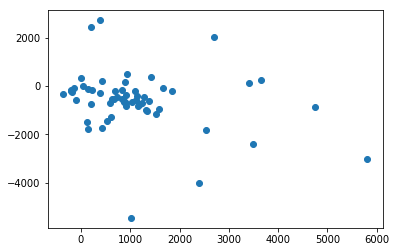

In [266]:
plt.scatter( pred.yhat[-1], pred.y )
print( rmse(pred.yhat[-1], pred.y.to_numpy() ) )

pred.y.to_numpy()[0] < 0.1
pred.y.loc[:,pred.y.to_numpy()[0] < 0.1].columns.values

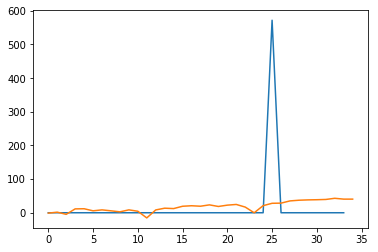

In [274]:
idx = 11
plt.plot( pred.ts_full[idx].to_numpy() )
plt.plot( pred.yhat[:,idx] )

850.1937132206989


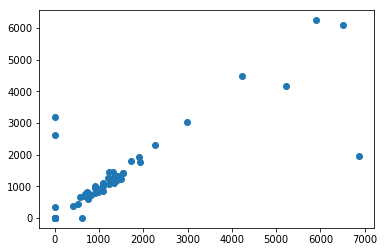

In [46]:
plt.scatter( pred.ts_full[-2:-1].to_numpy(), pred.ts_full[-1:].to_numpy() )
np.corrcoef( pred.ts_full[-2:-1].to_numpy(), pred.ts_full[-1:].to_numpy() )

base_mse = rmse( pred.ts_full[-2:-1].to_numpy(), pred.ts_full[-1:].to_numpy() )
print(base_mse)

2505.4803827564765


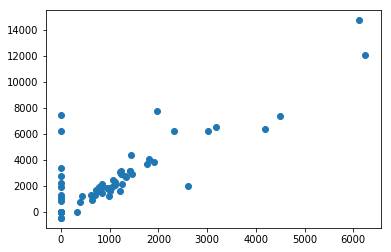

In [50]:
plt.scatter( pred.ts_full.to_numpy()[-1], pred.pca.inverse_transform(pred.yhat)[-1,:] )
np.corrcoef( pred.ts_full.to_numpy()[-1], pred.pca.inverse_transform(pred.yhat)[-1,:] )

mse_1 = rmse( pred.ts_full.to_numpy()[-1], pred.pca.inverse_transform(pred.yhat)[-1,:] )
print(mse_1)

In [6]:
# Create the pivot table containing sales for all shop and item combinations
sales_monthly_shop_item = create_pivot_ts( sales_monthly, 'shop_item_id' )

In [7]:
# Only keep the shop/item combinations that appear in the test set
Z = sales_monthly_shop_item.loc[ :, [ x in test.shop_item_id for x in sales_monthly_shop_item ] ]

In [8]:
def format_forecast( test_ids, fcst ):
    
    output = pd.Series( np.zeros_like(test_ids), index=test_ids, name="item_cnt_month" )

    # Copy the forecasts into the same order as the test IDs
    output[ fcst.index.values ] = fcst.values
    
    return(output)

In [654]:
# ATTEMPT 1: Test
y = Z.iloc[-1,:]
x = Z.iloc[-7:-2,:].mean()

test_output = format_forecast( y.index.values, x )

print( np.corrcoef( test_output, y)[0,1])
print( rmse(test_output, y ) )

0.4062118615697341
1.1650051392833263


In [664]:
# ATTEMPT 1: Print results

# Use the past 6 months to forecast
rolling_mean = Z.iloc[-6:-1,:].mean()

fcst = pd.Series( np.zeros_like( test.ID ), index=test.ID )
fcst[rolling_mean.index] = rolling_mean.values

output_1 = format_forecast( test.ID, fcst )
output_1.to_csv( 'forecast_1_v2.csv', index=True, header=True )

In [665]:
# ATTEMPT 2: Test
y = Z.iloc[-1,:]
x = Z.iloc[-7:-2,:].mean()

idx = ( 0.1 > Z.iloc[-2:-1,:].sum() )
x[idx] = 0

test_output = format_forecast( y.index.values, x )

print(np.corrcoef(x, y)[0,1])
print(rmse(x, y))

0.43417263371237413
1.1236472847479164


In [666]:
# ATTEMPT 2: Submission

# Use the past 6 months to forecast
rolling_mean = Z.iloc[-6:-1,:].mean()

# If the last 2 months have been 0, then forecast 0
idx = ( 0.1 > Z.iloc[-2:-1,:].sum() )
rolling_mean[idx] = 0

fcst = pd.Series( np.zeros_like( test.ID ), index=test.ID )
fcst[rolling_mean.index] = rolling_mean.values

output_2 = format_forecast( test.ID, fcst )
output_2.to_csv( 'forecast_2_v2.csv', index=True, header=True )

In [ ]:
# ATTEMPT 2: Test
y = Z.iloc[-1,:]
x = Z.iloc[-7:-2,:].mean()

idx = ( 0.1 > Z.iloc[-2:-1,:].sum() )
x[idx] = 0

test_output = format_forecast( y.index.values, x )

print(np.corrcoef(x, y)[0,1])
print(rmse(x, y))

In [760]:
%time

from sklearn.linear_model import LinearRegression

T, N = Z.shape

yhat = np.zeros(shape=(N,1), dtype=float )
y = Z.iloc[-1]

for k in range(N):

    if k % 1000 == 0:
        print(k)
        
    yy = Z.iloc[:-1,k].to_numpy().reshape(T-1,1)
    dy = (yy[1:] - yy[:-1])
    
    xx = np.array(list(range(1, T-1))).reshape(T-2,1)

    # model = LinearRegression()
    # model.fit( xx, dy )
    # yhat[k] = yy[-6:-1].mean() + model.predict(np.array([[T]]))
    yhat[k] = yy[-6:-1].mean()
    
# Make sure all values are greater than 0
yhat = np.maximum( yhat, 0 )

# Make sure all values that have been 0 for the past 2 observations are predicted to be 0
idx = ( 0.1 > Z.iloc[-2:-1,:].sum() )
yhat[idx] = 0

print( rmse( y, yhat.flat ))

CPU times: user 86 µs, sys: 48 µs, total: 134 µs
Wall time: 107 µs
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
1.1236472847479164


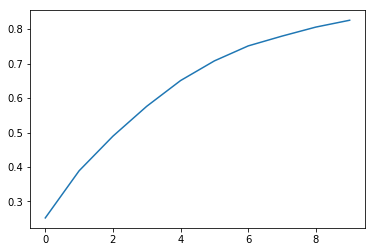

In [753]:
pca = PCA(n_components=10)
pca.fit(Z.iloc[:-1])

plt.plot( np.cumsum( pca.explained_variance_ratio_ ) )

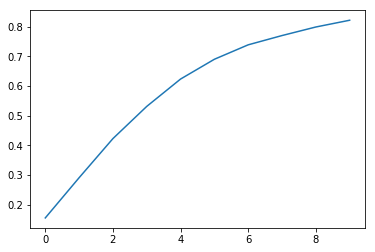

In [757]:
pca = PCA(n_components=10)
ZZ = Z.iloc[:-1].to_numpy()
dZ = ZZ[1:] - ZZ[:-1]
pca.fit(dZ)

plt.plot( np.cumsum( pca.explained_variance_ratio_ ) )

In [656]:
f1 = pd.read_csv( 'forecast_1.csv')
f1u = pd.read_csv( 'forecast_1_upload.csv')
f2 = pd.read_csv( 'forecast_2.csv')
f2u = pd.read_csv( 'forecast_2_upload.csv')
f3 = pd.read_csv( 'forecast_3.csv')

In [657]:
A = f1u.join(f1, on="ID", lsuffix="_upload", rsuffix="_1")
A.columns = [ "ID", "x_upload", "tmp", "x" ]
A = A[ [ "ID", "x_upload", "x" ] ]
A = A.set_index(A.ID)
A.head()

,ID,x_upload,x
ID,,,
2587,2587,0,0.0
7687,7687,0,0.0
12787,12787,0,0.0
17887,17887,0,0.0
22987,22987,0,0.0


In [658]:
A.describe()

,ID,x_upload,x
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,0.153688,0.024414
std,61834.358168,2.244372,0.312651
min,0.000000,0.000000,0.000000
25%,53549.750000,0.000000,0.000000
50%,107099.500000,0.000000,0.000000
75%,160649.250000,0.000000,0.000000
max,214199.000000,457.000000,71.400000


In [647]:
k = ( A.x_upload != A.x )
A[k].tail(10)

,ID,x_upload,x
ID,,,
163677,163677,0,NaN
168777,168777,0,NaN
173877,173877,0,NaN
178977,178977,0,NaN
184077,184077,0,NaN
189177,189177,0,NaN
194277,194277,0,NaN
199377,199377,0,NaN
204477,204477,1,NaN


In [761]:
sales_monthly.head()

,year_month,shop_id,item_id,item_category_id,shop_item_id,shop_cat_id,item_price,revenue,item_cnt_day
0,201301,0,32,40,3200,4000,221.0,1326.0,6.0
1,201301,0,33,37,3300,3700,347.0,1041.0,3.0
2,201301,0,35,40,3500,4000,247.0,247.0,1.0
3,201301,0,43,40,4300,4000,221.0,221.0,1.0
4,201301,0,51,57,5100,5700,128.5,257.0,2.0


In [762]:
sales_monthly_shop_item.head()

shop_item_id,54,155,254,354,454,554,654,754,854,954,...,2216756,2216757,2216758,2216759,2216802,2216812,2216816,2216842,2216843,2216925
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2013-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2013-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
SEED = 42
VALIDATION_PROPORTION = 0.1

def get_regression_vectors_from_matrix( input_mtx, is_X, seed=SEED, valid_prop=VALIDATION_PROPORTION ):

    N = input_mtx.shape[1]
    new_row = np.array( [np.NaN] * N ).reshape(1,N)    
    if is_X:
        M = np.vstack( [ new_row, input_mtx.to_numpy() ] )
    else:
        M = np.vstack( [ input_mtx.to_numpy(), new_row ] )

    # Randomly split the validation and training sets
    s_train_valid = M[:-1].ravel()[:,np.newaxis]
    s_train, s_valid = split_train_validation_sets( s_train_valid, seed=seed, valid_prop=valid_prop )
    
    # Get the test set
    s_test = M[-1].ravel()[:,np.newaxis]    

    return s_train, s_valid, s_test


def split_train_validation_sets( s, seed=SEED, valid_prop=VALIDATION_PROPORTION ):
    
    rng = np.random.RandomState(42)
    N = len(s)
    n_valid = int( np.floor( N * valid_prop ))
    
    idx = rng.choice(N, N, replace=False)
    s_valid = s[ idx[:n_valid] ]
    s_train = s[ idx[n_valid:] ]
    
    return s_train, s_valid
    

def remove_nan_rows( xx_input, yy_input ):
    idx = np.any( np.isnan( xx_input ), axis=1 ).ravel() | np.any( np.isnan( yy_input ), axis=1 ).ravel() 
    xx_output = xx_input[~idx,:]
    yy_output = yy_input[~idx,:]    
    return xx_output, yy_output
    
    
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:,:] - cumsum[:-N,:]) / float(N)

In [10]:
# Only keep the shop/item combinations that appear in the test set
W = sales_monthly_shop_item.loc[ :, [ x in test.shop_item_id for x in sales_monthly_shop_item ] ]
dW = W - W.shift(periods=1)
Z = dW

In [11]:
# Create the test and train sets from the observation matrices
yy_train, yy_valid, yy_test = get_regression_vectors_from_matrix( Z, is_X=False )
W_train, W_valid, W_test = get_regression_vectors_from_matrix( W, is_X=True)

# Get feature vectors
X_train = [None] * 23
X_test = [None] * 23
X_valid = [None] * 23

# Use different lags as features
c = 0
for j in range(0, 12):
    X_train[c], X_valid[c], X_test[c] = get_regression_vectors_from_matrix( Z.shift(periods=j), is_X=True)
    c += 1
    
# Get rolling means
for j in range(1, 12):
    # Calculate the rolling mean
    x_mean_mtx = Z.rolling(window=j+1).mean()
    X_train[c], X_valid[c], X_test[c] = get_regression_vectors_from_matrix(x_mean_mtx, is_X=True )
    c += 1

# Combine all of the X vectors into a single feature matrix
xx_train = np.hstack(X_train)
xx_valid = np.hstack(X_valid)
xx_test = np.hstack(X_test)

# Remove all rows with NaNs in the Train and Validation sets
# In the test set, all Y values are unknown, so we leave these alone
W_train, _ = remove_nan_rows( W_train, np.hstack( [ xx_train, yy_train ] ) )
W_valid, _ = remove_nan_rows( W_valid, np.hstack( [ xx_valid, yy_valid ] ) )

xx_train, yy_train = remove_nan_rows( xx_train, yy_train )
xx_valid, yy_valid = remove_nan_rows( xx_valid, yy_valid )


(60321, 1)

In [146]:
from sklearn.linear_model import LinearRegression, Ridge

%time
model = LinearRegression()
model.fit( xx_train, yy_train )

yhat = model.predict(xx_valid)

print(rmse( np.maximum(0, W_valid + yhat), W_valid + yy_valid))
print(rmse( yhat, yy_valid ) )

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
1.4310457030396138
1.4336546794462526


In [147]:
# Try Polynomial Regression

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

n_degrees = 2
res = np.zeros(shape=(n_degrees,1), dtype=float )
for d in range(0,n_degrees):
    polynomial_features = PolynomialFeatures(degree=d+1)
    x_poly_train = polynomial_features.fit_transform(xx_train)
    x_poly_valid = polynomial_features.fit_transform(xx_valid)

    model = LinearRegression()
    model.fit( x_poly_train, yy_train)
    yhat_poly = W_valid + model.predict(x_poly_valid)
    yhat_poly = np.maximum(0, yhat_poly)    
    
    res[d] = rmse( yhat_poly, W_valid + yy_valid)
    print( 'Degree {}: RMSE {}'.format(d+1, res[d]))

Degree 1: RMSE [1.43114801]
Degree 2: RMSE [1.37325791]


In [168]:
# Try ridge regression
from sklearn.linear_model import Ridge

n_degrees = 2
res = np.zeros(shape=(n_degrees,1), dtype=float )
for d in range(0,n_degrees):
    polynomial_features = PolynomialFeatures(degree=d+1)
    x_poly_train = polynomial_features.fit_transform(xx_train)
    x_poly_valid = polynomial_features.fit_transform(xx_valid)

    model = Ridge(alpha=0.1, normalize=True)
    model.fit(x_poly_train, yy_train)
    yhat_poly = W_valid + model.predict(x_poly_valid)
    yhat_poly = np.maximum(0, yhat_poly)

    res[d] = rmse( yhat_poly, W_valid + yy_valid)
    print( 'Degree {}: RMSE {}'.format(d+1, res[d]))
    

Degree 1: RMSE [1.42943655]
Degree 2: RMSE [1.37340396]


In [161]:
# Forecast 3-6 - use ridge regression with polynomial features of degree = 2

# Set up the model and transform the features
polynomial_features = PolynomialFeatures(degree=2)
x_poly_train = polynomial_features.fit_transform(xx_train)
x_poly_valid = polynomial_features.fit_transform(xx_valid)
x_poly_test = polynomial_features.fit_transform(xx_test)

# Fit the model using the training data
model = Ridge(alpha=0.1, normalize=True)
model.fit(x_poly_train, yy_train)

# Run the model on the validation set and see the score
yhat_valid = W_valid + model.predict(x_poly_valid)
yhat_valid = np.maximum(0, yhat_valid)
res = rmse( yhat_valid, W_valid + yy_valid)
print( 'Degree {}: RMSE {}'.format(d+1, res ) )

# Make a forecast using the test data
yhat_test = W_test + model.predict(x_poly_test)
yhat_test = np.maximum(0, yhat_test)

# Format the forecast as a Pandas Series and write the output to .csv
fcst_poly_ridge_reg = pd.Series( yhat_test.ravel(), index=pd.Index(Z.columns) )
output = format_forecast( test.ID, fcst_poly_ridge_reg )

# Make sure all values that have been 0 for the past 2 observations are predicted to be 0
idx = ( 0.1 > Z.iloc[-2:-1,:].sum() )
output[idx.index] = 0

output.to_csv( 'forecast_6.csv', index=True, header=True )

Degree 2: RMSE 1.373403961495297


In [ ]:
%time

# Try to model using decision trees
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

print('a')
# Set up the model and transform the features
polynomial_features = PolynomialFeatures(degree=1)
x_poly_train = polynomial_features.fit_transform(xx_train)
x_poly_valid = polynomial_features.fit_transform(xx_valid)
x_poly_test = polynomial_features.fit_transform(xx_test)
print('b')
# Fit the model using the training data
model = RandomForestRegressor(n_estimators=10, max_depth=2)
model.fit(x_poly_train, yy_train)
print('c')
# Run the model on the validation set and see the score
yhat_valid = W_valid + model.predict(x_poly_valid)[np.newaxis,:]
yhat_valid = np.maximum(0, yhat_valid)
print('d')
res = rmse( yhat_valid, W_valid + yy_valid)
print('e')
print( 'Degree {}: RMSE {}'.format(d+1, res ) )

# Make a forecast using the test data
yhat_test = W_test + model.predict(x_poly_test)[np.newaxis,:]
yhat_test = np.maximum(0, yhat_test)

# Format the forecast as a Pandas Series and write the output to .csv
fcst = pd.Series( yhat_test.ravel(), index=pd.Index(Z.columns) )
output = format_forecast( test.ID, fcst )

# Make sure all values that have been 0 for the past 2 observations are predicted to be 0
idx = ( 0.1 > Z.iloc[-2:-1,:].sum() )
output[idx.index] = 0

output.to_csv( 'forecast_7.csv', index=True, header=True )

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs
a
b
c


In [2]:
import pandas as pd
import numpy as np

File Not found
